In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter
import patsy
import emoji



%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [135]:
s_names = pd.read_csv("data/resp_id_join.csv")
s_names = s_names[['Respondent ID','First name', 'Last name']]
s_names.columns = ['Respondent ID','first_name', 'last_name']
sr = pd.read_csv("data/survey_joined_anon.csv")
#sr = sr.merge(s_names, how = 'left', on = 'Respondent ID')
ss = pd.read_csv("data/student_ids_survey_clean_3.csv")

# Need respondent ids for those ss-sr join
# ss['first_name'] = [name.split()[0] for name in ss.name]
# ss['last_name'] = [name.split()[1] if len(name.split()) == 2 else 'unknown' for name in ss.name]
# ss['first_name'] = ss['first_name'].str.lower()
# ss['last_name'] = ss['last_name'].str.lower()

#take the not found and opt out from the ss

ss = ss[(ss.respondent_id != 'not found') & (ss.respondent_id != 'opt out')]
ss['respondent_id'] = ss.respondent_id.astype(float)
sr = sr.merge(ss, how = 'left', left_on = 'ID', right_on = 'respondent_id')
sr_user = sr[(pd.notnull(sr['Post_Q1'])) & (pd.notnull(sr['User ID']))]

ques = pd.read_csv("data/resp_id_join.csv")
question_list = ques.columns[15:53]
question_list2 = question_list.append(question_list)
# sr['first_name'] = sr['first_name'].str.lower()
# sr['last_name'] = sr['last_name'].str.lower()
#45 students here's who's missing  -> ss[-ss.student_id.isin(sr.student_id)]
#and who we have sr[pd.notnull(sr.student_id)]

76

In [13]:
sr_user.groupby('PrevGrade')['ID'].count()

PrevGrade
A                    20
A+                   9 
A-                   7 
B                    9 
B+                   14
B-                   4 
C                    2 
C+                   2 
D+                   1 
Prefer not to say    5 
Name: ID, dtype: int64

* Grading a little skewed high. Maybe something interesting to look at.
* Would need to map to GP.

In [16]:
sr_user[sr_user.Treatment == 0]

,ID,PrevGrade,Section,Treatment,Pre_Q1,Pre_Q2,Pre_Q3,Pre_Q4,Pre_Q5,Pre_Q6,...,Post_Q37,Post_Q38,Post_Q39,Post_Q40,Post_Q41,Post_Q42,User ID,Name,Magic Code,respondent_id
425,5335038789,Prefer not to say,Reis - 814,0,Somewhat agree,Somewhat disagree,Somewhat agree,Disagree,Somewhat disagree,Somewhat disagree,...,Somewhat agree,Somewhat agree,1.0,0.0,0.0,0.0,560191.0,Juliette,NYC2D,5.335039e+09
428,5335048876,A,Reis - 814,0,Somewhat disagree,Strongly Agree,Agree,Agree,Strongly Disagree,Strongly Agree,...,Strongly Agree,Strongly Agree,1.0,1.0,0.0,1.0,560885.0,Sarwan Ansari,NYC2D,5.335049e+09
429,5335036885,A+,Reis - 814,0,Somewhat agree,Strongly Agree,Strongly Agree,Somewhat agree,Strongly Disagree,Somewhat agree,...,Somewhat agree,Agree,1.0,1.0,0.0,1.0,598184.0,Reda Arif,NYC2D,5.335037e+09
432,5335039025,A+,Reis - 814,0,Strongly Agree,Agree,Agree,Agree,Strongly Disagree,Agree,...,Agree,Agree,1.0,1.0,0.0,0.0,565984.0,Elham Chisty,NYC2D,5.335039e+09
435,5335038454,A-,Reis - 814,0,Agree,Agree,Somewhat agree,Agree,Somewhat disagree,Agree,...,Somewhat disagree,Somewhat agree,1.0,1.0,0.0,1.0,567586.0,MethelaNY Farhana,NYC2D,5.335038e+09
442,5335037930,B+,Reis - 814,0,Agree,Somewhat agree,Agree,Agree,Disagree,Agree,...,NaN,NaN,NaN,NaN,NaN,NaN,565991.0,Marqel McCollum,NYC2D,5.335038e+09
446,5335037251,A+,Reis - 814,0,Strongly Agree,Agree,Agree,Strongly Agree,Disagree,Agree,...,Agree,Strongly Agree,1.0,1.0,1.0,1.0,560596.0,Habiba Rahman,NYC2D,5.335037e+09
448,5335039063,C,Reis - 814,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree,Somewhat disagree,Agree,...,Agree,Disagree,1.0,0.0,0.0,0.0,565994.0,Kaylee Ramos,NYC2D,5.335039e+09
449,5335040153,A+,Reis - 814,0,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Disagree,Agree,...,Strongly Agree,Strongly Agree,1.0,1.0,1.0,0.0,565986.0,Harish Sharma,NYC2D,5.335040e+09


* 9 students not in the treatment used yup

In [36]:
sr_user.groupby('Pre_Q1')['ID'].count()

Pre_Q1
Agree                25
Disagree             4 
Somewhat agree       21
Somewhat disagree    7 
Strongly Agree       15
Strongly Disagree    1 
Name: ID, dtype: int64

In [44]:
sr_user.loc[373]

ID               5335335448       
PrevGrade        C                
Section          Reis - 807       
Treatment        1                
Pre_Q1           Strongly Disagree
Pre_Q2           Agree            
Pre_Q3           Disagree         
Pre_Q4           Strongly Disagree
Pre_Q5           Strongly Disagree
Pre_Q6           Strongly Agree   
Pre_Q7           Somewhat agree   
Pre_Q8           Strongly Agree   
Pre_Q9           Strongly Agree   
Pre_Q10          Strongly Agree   
Pre_Q11          Strongly Agree   
Pre_Q12          Strongly Agree   
Pre_Q13          Strongly Disagree
Pre_Q14          Strongly Agree   
Pre_Q15          Strongly Disagree
Pre_Q16          Strongly Disagree
Pre_Q17          Somewhat agree   
Pre_Q18          Disagree         
Pre_Q19          Strongly Disagree
Pre_Q20          Strongly Disagree
Pre_Q21          Strongly Agree   
Pre_Q22          Somewhat disagree
Pre_Q23          Disagree         
Pre_Q24          Strongly Agree   
Pre_Q25          Str

Possible questions of interest:
* Q1 => I learn math quickly.
* Q4 => I'm good at Math
Scrap that let's look at what changed and go from there



In [138]:
#Create agree/ disagree boolean for Q1-42
#Measure which has the most crossover in 


#Pre boolify
for i in range(38):
    i = i+1
    mask_agree = (sr_user['Pre_Q' + str(i)] == 'Agree') | \
(sr_user['Pre_Q' + str(i)] == 'Somewhat agree') | \
(sr_user['Pre_Q' + str(i)] == 'Strongly Agree')

    mask_disagree = (sr_user['Pre_Q' + str(i)] == 'Disagree') | \
(sr_user['Pre_Q' + str(i)] == 'Somewhat disagree') | \
(sr_user['Pre_Q' + str(i)] == 'Strongly Disagree')
    sr_user.loc[mask_agree, 'Pre_Q' + str(i)] = 1
    sr_user.loc[mask_disagree, 'Pre_Q' + str(i)] = 0
    sr_user['Pre_Q' + str(i)] = sr_user['Pre_Q' + str(i)].astype(int)
    
# Post boolify    
for i in range(38):
    i = i+1
    mask_agree = (sr_user['Post_Q' + str(i)] == 'Agree') | \
(sr_user['Post_Q' + str(i)] == 'Somewhat agree') | \
(sr_user['Post_Q' + str(i)] == 'Strongly Agree')

    mask_disagree = (sr_user['Post_Q' + str(i)] == 'Disagree') | \
(sr_user['Post_Q' + str(i)] == 'Somewhat disagree') | \
(sr_user['Post_Q' + str(i)] == 'Strongly Disagree')
    sr_user.loc[mask_agree, 'Post_Q' + str(i)] = 1
    sr_user.loc[mask_disagree, 'Post_Q' + str(i)] = 0
    sr_user['Post_Q' + str(i)] = sr_user['Post_Q' + str(i)].astype(int)
    
# Sorting out who went from disagree to agree
for i in range(38):
    i = i+1
    mask_change_mind = (sr_user['Pre_Q' + str(i)] == 0) &\
                  (sr_user['Pre_Q' + str(i)] != sr_user['Post_Q' + str(i)])
    sr_user.loc[mask_change_mind, 'change_Q' + str(i)] = 1
    sr_user.loc[-mask_change_mind, 'change_Q' + str(i)] = 0
    
# Sorting out who went from agree to disagree
for i in range(38):
    i = i+1
    mask_change_mind = (sr_user['Pre_Q' + str(i)] == 1) &\
                  (sr_user['Pre_Q' + str(i)] != sr_user['Post_Q' + str(i)])
    sr_user.loc[mask_change_mind, 'change_neg_Q' + str(i)] = 1
    sr_user.loc[-mask_change_mind, 'change_neg_Q' + str(i)] = 0

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [130]:
sr_user['pre_math_score'] =  sr_user['Pre_Q39'] + sr_user['Pre_Q40'] + sr_user['Pre_Q41'] + sr_user['Pre_Q42']
sr_user['post_math_score'] =  sr_user['Post_Q39'] + sr_user['Post_Q40'] + sr_user['Post_Q41'] + sr_user['Post_Q42']
sr_user['math_score_diff'] = sr_user['post_math_score'] - sr_user['pre_math_score']

In [140]:
posi_change =pd.DataFrame(sr_user[sr_user.columns[-76:]].sum())
posi_change['question'] = question_list2
posi_change.columns = ['count_change' , 'question']


In [141]:
posi_change.sort_values('count_change', ascending= False)

,count_change,question
change_Q15,13.0,"When studying for a hard math test, I either give up or only study the easy parts."
change_Q9,11.0,I get very tense when I have to do math homework.
change_Q30,11.0,"When I take a hard test, I think about how poorly I am doing."
change_neg_Q34,11.0,I work on math practice problems and exercises even when I don't have to.
change_Q25,11.0,Your intelligence is something about you that you can't change very much.
change_Q29,11.0,When my math homework is hard I either give up or only do the easy parts.
change_neg_Q7,11.0,I get very nervous doing math problems.
change_neg_Q36,10.0,Setbacks don't discourage me. I don't give up easily.
change_neg_Q33,10.0,You can learn new things but you can't really change your basic intelligence.
change_neg_Q31,10.0,My study skills are excellent compared with others in my math class.


* Top 8 for disagree -> agree
    * Q15= When studying for a hard math test, I either give up or only study the easy parts. 
        * Bad Change
    * Q25= Your intelligence is something about you that you can't change very much. 
        * Bad Change
    * Q9 = I get very tense when I have to do math homework.
        * Bad Change
    * Q30 = When I take a hard test, I think about how poorly I am doing.
        * Bad Change
    * Q29 = When my math homework is hard I either give up or only do the easy parts.
        * Bad Change

    * Q24 = I am so nervous during a math test that I cannot remember facts I have already learned.
        * Bad Change
    * Q19 = To be honest, you can't really change how intelligent you are. 
        * Bad Change
        
  
* Top positive change for disagree ->agree   
    * Q16 = In my math class, I understand even the most difficult concepts. 
        * 8 students
        * not gm
    * Q13 => I have always believed that math is one of my best subjects.
        * 8 students
        * not gm
    * Q20 = I am confident that I can understand graphs presented in newspapers.
        * 7 students
        * not gm
    * Q38 = I finish whatever I begin.
        * 7 students
        * gm
    * Q36 = Setbacks don't discourage me. I don't give up easily.
        * 7 students
        * gm
        
* Top positive change for agree -> disagree
    * Q33 -> You can learn new things but you can't really change your basic intelligence.
        * 10 students
        * gm
    * Q10 -> I often worry that it will be difficult for me in math class.
        * 8 students
        * gm
    * Q25 -> Your intelligence is something about you that you can't change very much.
        * 8 students
        * gm
    * Q9 -> I get very tense when I have to do math homework.
        * 7 students
        * not gm
    * Q11 = I feel helpless when doing a math problem.
        * 7 students
        * gm
        

In [115]:
ques = pd.read_csv("data/resp_id_join.csv")
question_list = ques.columns[15:53]

In [168]:
#Mark students as mindset changers based on all positively correlated questions with 7 or more students
changers_mask_7 = (sr_user["change_Q16"]==1) | (sr_user["change_Q13"]==1) | (sr_user["change_Q20"]==1) |\
(sr_user["change_Q38"]==1) | (sr_user["change_Q36"]==1) | (sr_user["change_neg_Q11"]==1) |\
(sr_user["change_neg_Q33"]==1) | (sr_user["change_neg_Q10"]==1) | (sr_user["change_neg_Q25"]==1) |\
(sr_user["change_neg_Q9"]==1)
#change_neg_Q6
changers_mask_7_gm = (sr_user["change_Q16"]==1) |\
(sr_user["change_Q38"]==1) | (sr_user["change_Q36"]==1) | (sr_user["change_neg_Q11"]==1) |\
(sr_user["change_neg_Q33"]==1) | (sr_user["change_neg_Q10"]==1) | (sr_user["change_neg_Q25"]==1)

In [170]:
sr_user.loc[changers_mask_7, 'posi_change'] = 1
sr_user.loc[-changers_mask_7, 'posi_change'] = 0
sr_user.loc[changers_mask_7_gm, 'posigm_change'] = 1
sr_user.loc[-changers_mask_7_gm, 'posigm_change'] = 0

In [152]:
# Session level data
ses = pd.read_csv("data/yup-sessions-2017-06-29.csv")
ses.columns = [col.strip() for col in ses.columns]
#Message Level Dat
msg = pd.read_csv("data/yup-messages-2017-06-29.csv")
#Student survey data
ss = pd.read_csv("data/students_survey.csv")

#column cleaning
msg['created_at_clean'] = pd.to_datetime(msg.created_at.astype(str).str[:-4], format='%Y-%m-%d %H:%M:%S', errors='ignore')
msg['text_readable'] = msg.sent_from +': '+ msg.text
ses['timestamp_clean'] = pd.to_datetime(ses.timestamp.astype(str).str[:-4], format='%Y-%m-%d %H:%M:%S', errors='ignore')
ses.loc[(ses.timestamp_clean >='2016-06-13 00:00:00') & (ses.timestamp_clean <= '2016-08-18 00:00:00'),'no_paywall'] = 1
ses.loc[(ses.timestamp_clean >='2016-03-16 00:00:00') & (ses.timestamp_clean <= '2016-04-12 00:00:00'),'no_paywall'] = 1
ses['no_paywall'] = ses.no_paywall.fillna(value=0)

#merge two tables
df_all = msg.merge(ses, on = 'session_id')
#subset out rubric questions and take out all uncategorized sessions
subset_cols =ses.columns[:42].append(ses.columns[-2:])
ses_1_42 = ses[subset_cols]
ses_1_42 = ses_1_42[-ses_1_42.consolidated_session_category.isin(['no-msg-sent', None, 'connection-issue'])]
ses_1_42['year-month'] = ses_1_42.timestamp_clean.astype(str).str[:7]

# New Transformations
ses_1_42.loc[ses_1_42.consolidated_session_category == "gap-bridged", 'gb_bool'] = 1
ses_1_42.loc[ses_1_42.consolidated_session_category != "gap-bridged", 'gb_bool'] = 0
ses_1_42['survey'] = 0
ses_1_42.loc[ses_1_42.student_id.isin(ss.student_id) , 'survey'] = 1 


/Users/ricky/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ricky/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [153]:
#Student-level data cleaning

# V1 : All students
#Groupbys to join
ses_cnt_by_student = ses_1_42.groupby('student_id').count()['session_id']
gb_cnt_by_student = ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged']\
.groupby('student_id').count()['session_id']
first_gb_by_student = ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged'].groupby('student_id')['timestamp_clean'].min()
first_session_by_student = ses_1_42.groupby('student_id')['timestamp_clean'].min()
most_used_platform_by_student = ses_1_42.groupby('student_id')['student_platform'].agg(lambda x:x.value_counts().index[0])

#Student level data cleaning and exploration
students = pd.DataFrame(ses_cnt_by_student).reset_index()
gbc = pd.DataFrame(gb_cnt_by_student).reset_index()
first_gb = pd.DataFrame(first_gb_by_student).reset_index()
first_session = pd.DataFrame(first_session_by_student).reset_index()
most_used_platform = pd.DataFrame(most_used_platform_by_student).reset_index()
bridged_ts = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged'].groupby('student_id')['timestamp_clean'].apply(np.array)).reset_index()
unbridged_ts = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category != 'gap-bridged'].groupby('student_id')['timestamp_clean'].apply(np.array)).reset_index()
last_ub = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category != 'gap-bridged'].groupby('student_id')['timestamp_clean'].max()).reset_index()
most_subject = pd.DataFrame(ses_1_42.groupby('student_id')['subject'].agg(lambda x:x.value_counts().index[0])).reset_index()

#merge into students df
students = students.merge(gbc, how = 'left' , on = 'student_id')
students = students.merge(first_gb,how = 'left' , on = 'student_id')
students = students.merge(last_ub ,how = 'left' , on = 'student_id')
students = students.merge(first_session ,how = 'left' , on = 'student_id')
students = students.merge(most_used_platform ,how = 'left' , on = 'student_id')
students = students.merge(most_subject ,how = 'left' , on = 'student_id')
students = students.merge(bridged_ts ,how = 'left' , on = 'student_id')
students = students.merge(unbridged_ts ,how = 'left' , on = 'student_id')

#rename columns
students.columns = ['student_id', 'session_count', 'gb_count', 'first_gb', 'last_ub', 'first_session', 'most_used_platform'\
                   ,'most_subject','bridged_ts_list', 'unbridged_ts_list']

#clean and create new columns
students['counter'] = students['session_count']
students['first_gb'] = students['first_gb'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))
students = students.fillna(value=0) #Note this created cells where NA -> 1970 dt object in first_gb column
students['gb_rate'] = 1.0*students.gb_count / students.session_count
students['time_to_gb'] = students.first_gb - students.first_session 
students['days_to_gb'] = students.time_to_gb.astype('timedelta64[D]')
students['days_to_gb'] = students['days_to_gb']+1 #to combat zero day in survival analysis
students.loc[students['first_gb'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1
students.loc[students['first_gb'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0
students.loc[students['last_ub'] > students['first_gb'], 'unbridged_after_gb'] = 1
students.loc[students['last_ub'] < students['first_gb'], 'unbridged_after_gb'] = 0

# merge all student level information
ses_1_42 = ses_1_42.merge(students, how = 'left', on = 'student_id')



#post merge session adding
ses_1_42['days_since_ses_1'] = (ses_1_42.timestamp_clean - ses_1_42.first_session ).astype('timedelta64[D]')
'''
#On hold until survival starts back up
#V2 : Limit to at least 5 gap bridged
students_gb5 = students[(students.gb_count > 4)]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]
students_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1

#V3 : At least 5 sessions, death defined as getting to 5 gap_bridged
students_gb5 = students[(students.session_count > 4)]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts5'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))
students_gb5.loc[students_gb5['bridged_ts5'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1
students_gb5.loc[students_gb5['bridged_ts5'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0
students_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1
#Subseting out system msgs
msg = msg[(msg.sent_from == 'student') | (msg.sent_from == 'tutor')]
msg = msg.drop_duplicates(['created_at', 'text'])
'''

"\n#On hold until survival starts back up\n#V2 : Limit to at least 5 gap bridged\nstudents_gb5 = students[(students.gb_count > 4)]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]\nstudents_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1\n\n#V3 : At least 5 sessions, death defined as getting to 5 gap_bridged\nstudents_gb5 = students[(students.session_count > 4)]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts5'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))\nstudents_gb5.loc[students_gb5['bridged_ts5'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1\nstudents_gb5.loc[students_gb5['bridged_ts5'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0\nstudents_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_s

In [154]:
#Subseting out system msgs
msg = msg[(msg.sent_from == 'student') | (msg.sent_from == 'tutor')]
msg = msg.drop_duplicates(['created_at', 'text'])

# Count total, tutor and student msg counts
msg_count_by_ses = pd.DataFrame(msg.groupby('session_id').count()['created_at']).reset_index()
msg_stu_count_by_ses = pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id').count()['created_at']).reset_index()
msg_tut_count_by_ses = pd.DataFrame(msg[(msg.sent_from == 'tutor')].groupby('session_id').count()['created_at']).reset_index()
msg_count_by_ses.columns = ['session_id', 'total_count_msg']
msg_stu_count_by_ses.columns = ['session_id', 'stu_count_msg']
msg_tut_count_by_ses.columns = ['session_id', 'tut_count_msg']

#gone mergin'
ses_1_42 = ses_1_42.merge(msg_count_by_ses, how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(msg_stu_count_by_ses, how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(msg_tut_count_by_ses, how = 'left', on = 'session_id')

#Take text and count words and put into df to join to session master data set
msg['text'] = msg['text'].astype(str)
msg['text_lower'] = [t.lower() for t in msg.text]
full_transcript_by_session = pd.DataFrame(msg[msg.content_type == 'text'].groupby('session_id')['text'].apply(list)).reset_index()
joined_text = [" ".join(transcript) for transcript in  full_transcript_by_session.text]
split_of_transcript = [t.split() for t in joined_text]
length_list = [len(t) for t in split_of_transcript]
char_list = [len(t) for t in joined_text]
question_count_list = [t.count('?') for t in joined_text]
msg_question_count =  [t.count('?') for t in msg.text]

full_transcript_by_session['text'] = joined_text
full_transcript_by_session['word_count'] = length_list
full_transcript_by_session['char_count'] = char_list
full_transcript_by_session['question_count'] = question_count_list
ses_1_42 = ses_1_42.merge(full_transcript_by_session, how = 'left', on = 'session_id')

ques_start = ['how', 'what', 'when' , 'where' , 'why', 'who']
for word in ques_start:
    _ls_start = [t.strip()[:len(word)].count(word) for t in msg.text_lower]
    _ls_any = [t.count(word) for t in msg.text_lower]
    msg[word + '_start'] = _ls_start
    msg[word + '_any'] = _ls_any
    
def emoji_list_search(ls):
    for item in ls:
        if unicode(item, 'utf-8') in emoji.UNICODE_EMOJI:
            return 1.0
    return 0.0

lower_msg_split = [t.split() for t in msg.text_lower]
msg["emoji_bool"] = [emoji_list_search(ls) for ls in lower_msg_split]

msg['question_student_count'] = np.array([1 if t.count("?")>0 else 0 for t in msg.text_lower])
msg['first_word'] = [ None if t.split()==[] else t.split()[0] for t in msg.text_lower]

sum_msg_vars = ['how_start', 'what_start', 'when_start' , 'where_start' , 'why_start', 'who_start',\
                    'how_any', 'what_any', 'when_any' , 'where_any' , 'why_any', 'who_any',\
                   'emoji_bool']
ques_start_any = []
#merging question start counts for start of msg and anywhere in message
ses_1_42 = ses_1_42.merge(pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id')[sum_msg_vars].sum()).reset_index(), how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id')['question_student_count'].sum()).reset_index(), how = 'left', on = 'session_id')

ses_1_42['high_level'] = ses_1_42['why_any'] + ses_1_42['how_any']
ses_1_42['low_level'] = ses_1_42['where_any'] + ses_1_42['when_any'] + ses_1_42['what_any'] + ses_1_42['who_any']
ses_1_42['high_level_ratio'] = ses_1_42['high_level'] / pd.Series([1.0 if num == 0.0 else num for num in ses_1_42.low_level])
#Note missing values found here -> #ses_1_42[(pd.isnull(ses_1_42.word_count))
#no message data for 5K sessions
# here are gb with no msg data: ses_1_42[(pd.isnull(ses_1_42.word_count)) &\(ses_1_42.consolidated_session_category == 'gap-bridged')]['session_id']
#All the sessions without missing message data
# some may be no stud msg, connection isuue, etc
ses_full = ses_1_42[(pd.notnull(ses_1_42.word_count))]
ses_full['ses_num_order'] = ses_full.groupby('student_id').cumcount()
ses_full['ses_num_order'] = ses_full['ses_num_order'] + 1

#This creates incompleteness here as well 
#to correct I'll filter out all student ids that appear in sessions without message data
students_full = students[-students.student_id.isin(ses_1_42[pd.isnull(ses_1_42.word_count)]['student_id'])]

#merging student session group by to apprpriate stduent population
students_full = students_full.merge(pd.DataFrame(ses_full.groupby('student_id')['question_student_count'].sum()).reset_index(), how = 'left', on = 'student_id')

students_full['question_student_count_ratio'] = 1.0*students_full['question_student_count'] / students_full['session_count']



/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [216]:
sr_join = sr_user[['User ID', 'posi_change', 'posigm_change', 'math_score_diff', 'pre_math_score', 'post_math_score']]
sr_join.loc[sr_join.math_score_diff > 0, 'ms_improve'] = 1
sr_join.loc[sr_join.math_score_diff <= 0, 'ms_improve'] = 0

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [217]:
sr_join = sr_join.merge(students, how = 'left', left_on = 'User ID', right_on = 'student_id')

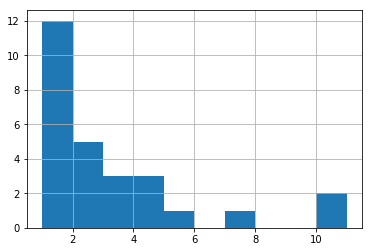

In [218]:
sr_join[sr_join['posigm_change']==1].session_count.hist()

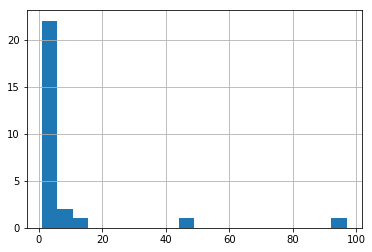

In [219]:
sr_join[sr_join['posigm_change']==0].session_count.hist(bins = 20)

* We see two major outliers swaying the data.
* We are going to see how big an effect they have on the mean session and gb_rate

In [184]:
#outliers are taken out 563980(97 sessions) and 565474 (47 sessions)
sr_join[(sr_join.student_id != 565474) & (sr_join.student_id != 563980)].groupby('posigm_change').mean().T

posigm_change,0.0,1.0
User ID,560671.344828,557923.281250
posi_change,0.275862,1.000000
student_id,560664.520000,557182.296296
session_count,3.120000,2.851852
gb_count,1.240000,0.851852
counter,3.120000,2.851852
gb_rate,0.315250,0.262907
days_to_gb,31.920000,42.629630
observed,0.520000,0.370370
unbridged_after_gb,0.280000,0.185185


* We saw very little change in the rates.
* Results are unuseful for external communication. But should be added to the internal report.

In [220]:
sr_join.groupby('posigm_change').mean().T

posigm_change,0.0,1.0
User ID,560933.000000,557923.281250
posi_change,0.258065,1.000000
math_score_diff,0.129032,0.258065
pre_math_score,2.000000,1.781250
post_math_score,2.129032,2.064516
ms_improve,0.419355,0.387097
student_id,560965.444444,557182.296296
session_count,8.222222,2.851852
gb_count,2.888889,0.851852
counter,8.222222,2.851852


* Those students that exibited a change in mindset over the studied period also showed improvements in math score accross the studied period.
    * Can we link this to yup usage?
    * Almost half of studied students improved math scores

In [221]:
sr_join.groupby('ms_improve').mean().T

ms_improve,0.0,1.0
User ID,561971.135135,555570.520000
posi_change,0.594595,0.680000
posigm_change,0.513514,0.480000
math_score_diff,-0.513514,1.240000
pre_math_score,2.243243,1.400000
post_math_score,1.729730,2.640000
student_id,561788.343750,554880.428571
session_count,7.750000,2.285714
gb_count,2.718750,0.666667
counter,7.750000,2.285714


In [222]:
sr_join[(sr_join.student_id != 565474) & (sr_join.student_id != 563980)].groupby('ms_improve').mean().T

ms_improve,0.0,1.0
User ID,561813.657143,555570.520000
posi_change,0.628571,0.680000
posigm_change,0.542857,0.480000
math_score_diff,-0.514286,1.240000
pre_math_score,2.285714,1.400000
post_math_score,1.771429,2.640000
student_id,561592.433333,554880.428571
session_count,3.466667,2.285714
gb_count,1.333333,0.666667
counter,3.466667,2.285714


* Those students that improved their math score. Had lower gap bridged rates and lower session counts.
* As seen before margins narrow but do not converge without outliers.

In [233]:

print sum(sr_join.ms_improve == 1)
print '25/63 improved math scores' # < - MVP

25
25/63 improved math scores


In [232]:
sum(sr_join.math_score_diff >=0)
print '46/63 did not decrease surveyed math scores'

46/63 did not decrease surveyed math scores
